# Hierarchical VAE

NVAE, [arXiv:2007.03898 [stat.ML]](https://arxiv.org/abs/2007.03898)

VDVAE, [arXiv:2011.10650 [cs.LG]](https://arxiv.org/abs/2011.10650)

VDVAE GitHub: https://github.com/openai/vdvae

Latent variables $\boldsymbol{z}$ are split into $L$ layers $\boldsymbol{z}_i$, $i=1\ldots L$. Prior distribution
$$
p_{\boldsymbol{\theta}}(\boldsymbol{z})=p(\boldsymbol{z}_{L})\prod_{i=1}^{L-1}p_{\boldsymbol{\theta}}(\boldsymbol{z}_{i}|\boldsymbol{z}_{i<})\,.
$$
Inference (encoder):
$$
q_{\boldsymbol{\phi}}(\boldsymbol{z}|\boldsymbol{x})=q_{\boldsymbol{\phi}}(\boldsymbol{z}_{L}|\boldsymbol{x})\prod_{i=1}^{L-1}q_{\boldsymbol{\phi}}(\boldsymbol{z}_{i}|\boldsymbol{z}_{i<},\boldsymbol{x})\,.
$$
ELBO takes the form
$$
\log p(\boldsymbol{x})\geq\mathbb{E}_{q_{\boldsymbol{\phi}}(\boldsymbol{z}|\boldsymbol{x})}[\log p_{\boldsymbol{\theta}}(\boldsymbol{x}|\boldsymbol{z})]-D_{\mathrm{KL}}(q_{\boldsymbol{\phi}}(\boldsymbol{z}|\boldsymbol{x})||p_{\boldsymbol{\theta}}(\boldsymbol{z}))\,,
$$
where the Kullback-Leibler divergence is
$$
D_{\mathrm{KL}}(q_{\boldsymbol{\phi}}(\boldsymbol{z}|\boldsymbol{x})||p_{\boldsymbol{\theta}}(\boldsymbol{z}))=D_{\mathrm{KL}}(q_{\boldsymbol{\phi}}(\boldsymbol{z}_{L}|\boldsymbol{x})||p(\boldsymbol{z}_{L}))+\sum_{i=1}^{L-1}\mathbb{E}_{q_{\boldsymbol{\phi}}(\boldsymbol{z}_{i<}|\boldsymbol{x})}[D_{\mathrm{KL}}(q_{\boldsymbol{\phi}}(\boldsymbol{z}_{i}|\boldsymbol{z}_{i<},\boldsymbol{x})||p_{\boldsymbol{\theta}}(\boldsymbol{z}_{i}|\boldsymbol{z}_{i<}))]\,.
$$
Here we introduced
$$
q_{\boldsymbol{\phi}}(\boldsymbol{z}_{i<}|\boldsymbol{x})=q_{\boldsymbol{\phi}}(\boldsymbol{z}_{L}|\boldsymbol{x})\prod_{j=i+1}^{L-1}q_{\boldsymbol{\phi}}(\boldsymbol{z}_{j}|\boldsymbol{z}_{j<},\boldsymbol{x})
$$
Assuming Gaussian distributions
$$
\begin{aligned}
p(\boldsymbol{z}_{L})&=\mathcal{N}(\boldsymbol{z}_{L},\boldsymbol{0},\boldsymbol{I})\,,\\
p_{\boldsymbol{\theta}}(\boldsymbol{z}_{i}|\boldsymbol{z}_{i<})&=\mathcal{N}(\boldsymbol{z}_{i},\boldsymbol{\mu}_{\boldsymbol{\theta},i}(\boldsymbol{z}_{i<}),\sigma_{\boldsymbol{\theta},i}^{2}(\boldsymbol{z}_{i<})\boldsymbol{I})\,,\\
q_{\boldsymbol{\phi}}(\boldsymbol{z}_{L}|\boldsymbol{x})&=\mathcal{N}(\boldsymbol{z}_{L},\boldsymbol{\mu}_{\boldsymbol{\phi},L}(\boldsymbol{x}),\boldsymbol{\sigma}_{\boldsymbol{\phi},L}^{2}(\boldsymbol{x})\boldsymbol{I})\,,\\
q_{\boldsymbol{\phi}}(\boldsymbol{z}_{i}|\boldsymbol{z}_{i<},\boldsymbol{x})&=\mathcal{N}(\boldsymbol{z}_{i},\boldsymbol{\mu}_{\boldsymbol{\phi},i}(\boldsymbol{z}_{i<},\boldsymbol{x}),\boldsymbol{\sigma}_{\boldsymbol{\phi},i}^{2}(\boldsymbol{z}_{i<},\boldsymbol{x})\boldsymbol{I})
\end{aligned}
$$
Kullback-Leibler divergence becomes
$$
D_{\mathrm{KL}} = \frac{1}{2}\sum_{j=1}^{D_{L}}\left(\mu_{\boldsymbol{\phi},L}^{(j)2}+\sigma_{\boldsymbol{\phi},L}^{(j)2}-\log\sigma_{\boldsymbol{\phi},L}^{(j)2}-1\right)
+\frac{1}{2}\sum_{i=1}^{L-1}\sum_{j=1}^{D_{i}}\left(\frac{(\mu_{\boldsymbol{\phi},i}^{(j)}-\mu_{\boldsymbol{\theta},i}^{(j)})^{2}}{\sigma_{\boldsymbol{\theta},i}^{(j)2}}+\frac{\sigma_{\boldsymbol{\phi},i}^{(j)2}}{\sigma_{\boldsymbol{\theta},i}^{(j)2}}-\log\frac{\sigma_{\boldsymbol{\phi},i}^{(j)2}}{\sigma_{\boldsymbol{\theta},i}^{(j)2}}-1\right)
$$

## Configuration

Imports

In [1]:
from pathlib import Path
from functools import partial
from collections import defaultdict
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vision_utils

Configuration

In [2]:
DATA_DIR = Path("./data")
MODELS_DIR = Path("./models")

NUM_WORKERS = 8
BATCH_SIZE = 128

IMAGE_SIZE = 128
IMAGE_CHANNELS = 3
ENCODER_CHANNELS = 16
LATENT_REDUCTION = 16 # ratio of the number of feature channels to the number of latent channels
NUM_DOWNSAMPLINGS = 5

EPOCHS = 40
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-2

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

### Utilities

In [4]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act=True):
        padding = (kernel_size - 1) // 2
        layers = [
          nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
          nn.BatchNorm2d(out_channels)
        ]
        if act: layers.append(nn.ReLU(inplace=True))
        super().__init__(*layers)

In [5]:
def reparameterize(mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + std * eps

In [6]:
def kl_divergence(mu, log_var, mu_prior, log_var_prior):
    d_mu = mu - mu_prior
    d_log_var = log_var - log_var_prior
    kld = 0.5 * (d_mu**2 / log_var_prior.exp() + d_log_var.exp() - d_log_var - 1)
    return kld

In [7]:
def init_model(model):
    for m in model.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None: nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

### Encoder

In [8]:
class DownBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels, 3)
        )

In [9]:
class Encoder(nn.Module):
    def __init__(self, in_channels, channels, num_downsamplings):
        super().__init__()
        self.stem = ConvBlock(in_channels, channels, 3)
        
        self.blocks = nn.ModuleList()
        in_channels = channels
        for _ in range(num_downsamplings):
            out_channels = in_channels * 2
            self.blocks.append(DownBlock(in_channels, out_channels))
            in_channels = out_channels
    
    def forward(self, x):
        x = self.stem(x)
        
        xs = []
        for block in self.blocks:
            xs.append(x)
            x = block(x)
        return x, xs

### VAE for skip connections

In [10]:
class VAELayer(nn.Module):
    def __init__(self, channels, latent_reduction):
        super().__init__()
        latent_channels = channels // latent_reduction
        # nn.Conv2d with BatchNorm stabilizes KL losses
        self.to_prior = ConvBlock(channels, 2 * latent_channels, 3, act=False)
        self.encoder = ConvBlock(channels, 2 * latent_channels, 3, act=False)
        self.decoder = ConvBlock(latent_channels, channels, 3, act=False)
        
        self.γ = nn.Parameter(torch.zeros(1))
        self.act = nn.ReLU(inplace=True)
    
    def forward(self, x, x_prior):
        mu_prior, log_var_prior = self.to_prior(x_prior).chunk(2, dim=1)
        mu, log_var = self.encoder(x).chunk(2, dim=1)
        z = reparameterize(mu, log_var)
        kld = kl_divergence(mu, log_var, mu_prior, log_var_prior)
        z = self.decoder(z)
        
        out = x_prior + self.γ * z
        out = self.act(out)
        return out, kld
    
    def sample(self, x_prior, t=1.):
        mu_prior, log_var_prior = self.to_prior(x_prior).chunk(2, dim=1)
        log_var_prior = log_var_prior + torch.ones_like(log_var_prior) * np.log(t)
        z = reparameterize(mu_prior, log_var_prior)
        z = self.decoder(z)
        out = x_prior + self.γ * z
        out = self.act(out)
        return out

### Decoder

In [11]:
class DecoderStem(nn.Module):
    def __init__(self, channels, latent_reduction, shape):
        super().__init__()
        self.vae = VAELayer(channels, latent_reduction)
        self.prior = nn.Parameter(torch.zeros(1, channels, *shape))
    
    def forward(self, x):
        out, kld = self.vae(x, self.prior)
        return out, kld
    
    def sample(self, num_samples, t=1.):
        out = self.vae.sample(self.prior.expand(num_samples, -1, -1, -1), t=t)
        return out

In [12]:
class UpBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.Upsample(scale_factor=2, mode='nearest'),
            ConvBlock(in_channels, out_channels, 3)
        )

In [13]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, latent_reduction):
        super().__init__()
        self.up = UpBlock(in_channels, out_channels)
        self.vae = VAELayer(out_channels, latent_reduction)
    
    def forward(self, x, skip):
        x = self.up(x)
        out, kld = self.vae(skip, x)
        return out, kld
    
    def sample(self, x, t=1.):
        x = self.up(x)
        out = self.vae.sample(x, t=t)
        return out

In [14]:
class DecoderHead(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            ConvBlock(in_channels, out_channels, 3, act=False),
            nn.Sigmoid()
        )

In [15]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, latent_reduction, num_upsamplings, shape):
        super().__init__()
        self.stem = DecoderStem(in_channels, latent_reduction, shape)
        
        self.blocks = nn.ModuleList()
        for _ in range(num_upsamplings):
            channels = in_channels // 2
            self.blocks.append(DecoderBlock(in_channels, channels, latent_reduction))
            in_channels = channels
        
        self.head = DecoderHead(channels, out_channels)
    
    def forward(self, x, xs):
        klds = []
        x, kld = self.stem(x)
        klds.append(kld)
        
        for block, skip in zip(self.blocks, reversed(xs)):
            x, kld = block(x, skip)
            klds.append(kld)
        x = self.head(x)
        return x, klds
    
    def sample(self, num_samples, t=1.):
        z  = self.stem.sample(num_samples, t=t)
        for block in self.blocks:
            z = block.sample(z, t)
        z = self.head(z)
        return z

### Full VAE

In [16]:
class VAE(nn.Module):
    def __init__(self, num_downsamplings, latent_reduction, enc_channels, image_shape, in_channels=3):
        super().__init__()
        reduction = 2**num_downsamplings
        shape = (image_shape[0] // reduction, image_shape[1] // reduction)
        self.encoder = Encoder(in_channels, enc_channels, num_downsamplings)
        self.decoder = Decoder(enc_channels * reduction, in_channels, latent_reduction, num_downsamplings, shape)

    def forward(self, x):
        x, xs = self.encoder(x)
        out, klds = self.decoder(x, xs)
        return out, klds
    
    def sample(self, num_samples, t=1.):
        with torch.no_grad():
            out = self.decoder.sample(num_samples, t)
        return out

### Model creation

In [17]:
model = VAE(num_downsamplings=NUM_DOWNSAMPLINGS, latent_reduction=LATENT_REDUCTION, enc_channels=ENCODER_CHANNELS,
            image_shape=(IMAGE_SIZE, IMAGE_SIZE), in_channels=IMAGE_CHANNELS)

In [18]:
init_model(model)

In [19]:
model = model.to(DEVICE)

In [20]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))
print("Number of encoder parameters: {:,}".format(sum(p.numel() for p in model.encoder.parameters())))
print("Number of decoder parameters: {:,}".format(sum(p.numel() for p in model.decoder.parameters())))

Number of parameters: 4,140,052
Number of encoder parameters: 1,573,776
Number of decoder parameters: 2,566,276


## Loss

In [21]:
class VAELoss(nn.Module):
    def __init__(self, β=1.):
        super().__init__()
        self.reconstruction_loss = nn.L1Loss()
        self.β = β
    
    def forward(self, outputs, target):
        output, klds = outputs
        reconst_loss = self.reconstruction_loss(output, target)
        kld_losses = [torch.mean(kld) for kld in klds]
        
        ndims = np.prod(output.shape[1:])
        nlatent = np.array([np.prod(kld.shape[1:]) for kld in klds])
        kld_weights = self.β * nlatent / ndims
        
        total_kld_loss = sum(weight * kld_loss for weight, kld_loss in zip(kld_weights, kld_losses))
        loss = reconst_loss + total_kld_loss
        
        loss_dict = {"loss": loss, "reconstruction loss": reconst_loss}
        for num, kld_loss in enumerate(kld_losses):
            loss_dict[f"KLD{num}"] = kld_loss
        
        return loss_dict

## Utilities

In [22]:
def plot_batch(ax, batch, title=None, **kwargs):
    imgs = vision_utils.make_grid(batch, padding=2, normalize=True)
    imgs = np.moveaxis(imgs.numpy(), 0, -1)
    ax.set_axis_off()
    if title is not None: ax.set_title(title)
    return ax.imshow(imgs, **kwargs)

In [23]:
def show_images(batch, title):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plot_batch(ax, batch, title)
    plt.show()

In [24]:
def show_2_batches(batch1, batch2, title1, title2):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(121)
    plot_batch(ax, batch1, title1)

    ax = fig.add_subplot(122)
    plot_batch(ax, batch2, title2)
    plt.show()

In [25]:
def reconstruct(model, batch, device):
    batch = batch.to(device)
    with torch.no_grad():
        reconstructed_batch = model(batch)[0]
    reconstructed_batch = reconstructed_batch.cpu()
    return reconstructed_batch

## Data

In [28]:
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [29]:
val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()
])

In [30]:
train_dset = datasets.CelebA(str(DATA_DIR), split='train', transform=train_transform, download=False)
val_dset = datasets.CelebA(str(DATA_DIR), split='test', transform=val_transform, download=False)

In [31]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS)

val_loader = torch.utils.data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False,
                                         num_workers=NUM_WORKERS)

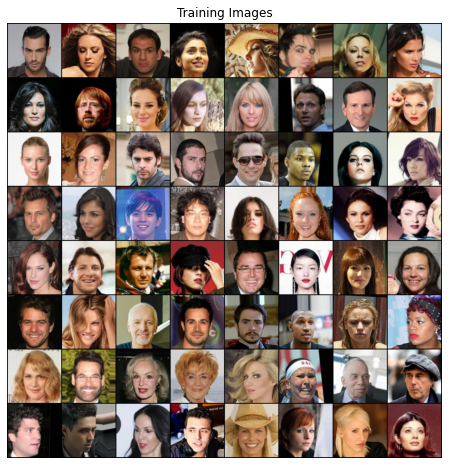

In [32]:
test_batch, _ = next(iter(train_loader))
show_images(test_batch[:64], "Training Images")

## Training

### Learner

In [33]:
class AverageLoss():
    def __init__(self, name):
        self.name = name
        self.reset()
    
    def reset(self):
        self.num_samples = 0
        self.total_loss = 0.
    
    def update(self, data):
        batch_size = data['batch_size']
        self.num_samples += batch_size
        self.total_loss += batch_size * data[self.name]
        
    def compute(self):
        avg_loss = self.total_loss / self.num_samples
        metrics = {self.name: avg_loss}
        return metrics

In [34]:
class Learner:
    def __init__(self, model, loss, optimizer, train_loader, val_loader, device,
                 batch_scheduler=None, epoch_scheduler=None):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.batch_scheduler = batch_scheduler
        self.epoch_scheduler = epoch_scheduler
        self.history = defaultdict(list)
        
        self.metrics = [AverageLoss(x) for x in ["loss", "reconstruction loss"]]
        for num in range(NUM_DOWNSAMPLINGS + 1):
            self.metrics.append(AverageLoss(f"KLD{num}"))
    
    def iterate(self, loader, train=False):
        for metric in self.metrics:
            metric.reset()
        
        for batch in loader:
            images = batch[0].to(self.device)
            outputs = self.model(images)
            losses = self.loss(outputs, images)
            
            if train: self.backward_pass(losses["loss"])
            
            data = {k: v.item() for k, v in losses.items()}
            data["batch_size"] = len(images)
            
            for metric in self.metrics:
                metric.update(data)
        
        summary = {}
        for metric in self.metrics:
            summary.update(metric.compute())
        return summary
    
    def backward_pass(self, batch_loss):
        self.optimizer.zero_grad()
        batch_loss.backward()
        self.optimizer.step()

        if self.batch_scheduler is not None:
            self.batch_scheduler.step()
    
    def log_metrics(self, metrics, name):
        print(f"{name}: ", end='', flush=True)
        for key, val in metrics.items():
            self.history[name + ' ' + key].append(val)
            print(f"{key} {val:.4f} ", end='')
    
    def train(self):
        self.model.train()
        metrics = self.iterate(self.train_loader, train=True)
        self.log_metrics(metrics, 'train')
    
    def validate(self):
        self.model.eval()
        with torch.no_grad():
            metrics = self.iterate(self.val_loader)
        self.log_metrics(metrics, 'val')
    
    def fit(self, epochs):
        for epoch in range(1, epochs + 1):
            print(f"{epoch}/{epochs}:")
            self.train()
            print()
            self.validate()
            print()
            if self.epoch_scheduler is not None:
                self.epoch_scheduler.step()
        
        torch.save(model.state_dict(), str(MODELS_DIR / 'final_model.pt'))

In [35]:
def plot_history_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.grid()
    ax.legend()
    plt.show()

### Start training

In [36]:
loss = VAELoss(β=1.)

In [37]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [38]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [39]:
learner = Learner(model, loss, optimizer, train_loader, val_loader, DEVICE, batch_scheduler=lr_scheduler)

In [40]:
learner.fit(EPOCHS)

1/40:
train: loss 0.1771 reconstruction loss 0.1010 KLD0 0.1495 KLD1 0.0527 KLD2 0.1716 KLD3 0.1206 KLD4 0.1180 KLD5 0.1096 
val: loss 0.0816 reconstruction loss 0.0598 KLD0 0.0609 KLD1 0.0361 KLD2 0.1066 KLD3 0.0455 KLD4 0.0283 KLD5 0.0223 
2/40:
train: loss 0.0735 reconstruction loss 0.0544 KLD0 0.0480 KLD1 0.0578 KLD2 0.0958 KLD3 0.0547 KLD4 0.0204 KLD5 0.0164 
val: loss 0.0661 reconstruction loss 0.0488 KLD0 0.0436 KLD1 0.0859 KLD2 0.0883 KLD3 0.0607 KLD4 0.0143 KLD5 0.0119 
3/40:
train: loss 0.0634 reconstruction loss 0.0476 KLD0 0.0409 KLD1 0.1057 KLD2 0.0891 KLD3 0.0592 KLD4 0.0102 KLD5 0.0085 
val: loss 0.0639 reconstruction loss 0.0485 KLD0 0.0427 KLD1 0.1181 KLD2 0.0922 KLD3 0.0583 KLD4 0.0081 KLD5 0.0073 
4/40:
train: loss 0.0587 reconstruction loss 0.0449 KLD0 0.0478 KLD1 0.1161 KLD2 0.0907 KLD3 0.0563 KLD4 0.0058 KLD5 0.0041 
val: loss 0.0564 reconstruction loss 0.0432 KLD0 0.0542 KLD1 0.1110 KLD2 0.0923 KLD3 0.0556 KLD4 0.0054 KLD5 0.0028 
5/40:
train: loss 0.0556 reconst

### Plotting

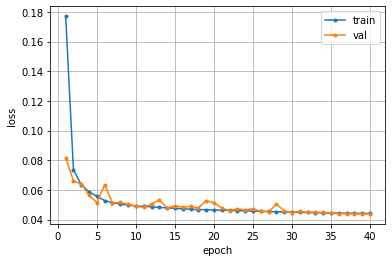

In [41]:
plot_history_train_val(learner.history, 'loss')

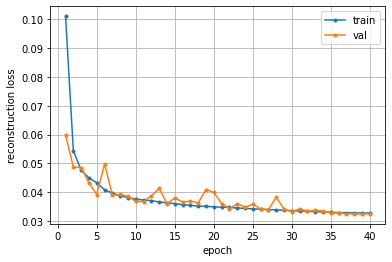

In [42]:
plot_history_train_val(learner.history, 'reconstruction loss')

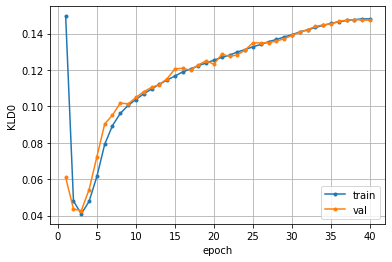

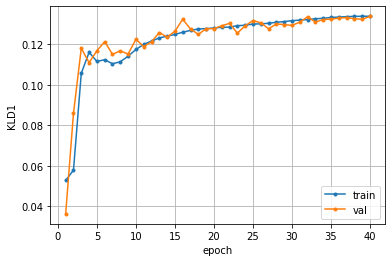

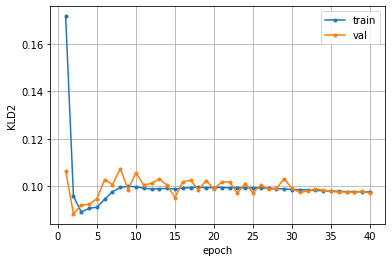

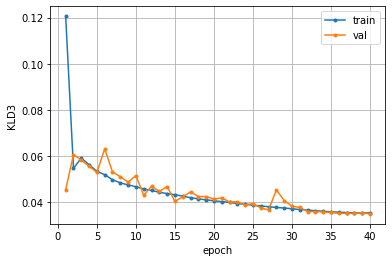

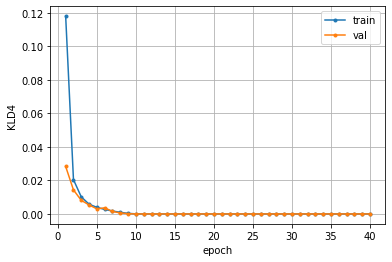

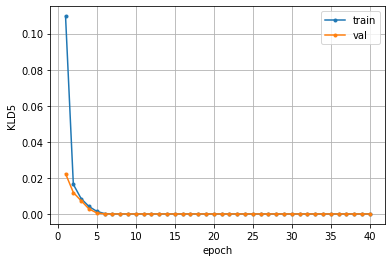

In [43]:
for num in range(NUM_DOWNSAMPLINGS + 1):
    plot_history_train_val(learner.history, f'KLD{num}')

## Testing

In [44]:
model.load_state_dict(torch.load(str(MODELS_DIR / 'final_model.pt')))

<All keys matched successfully>

In [45]:
model.eval();

Testing reconstruction

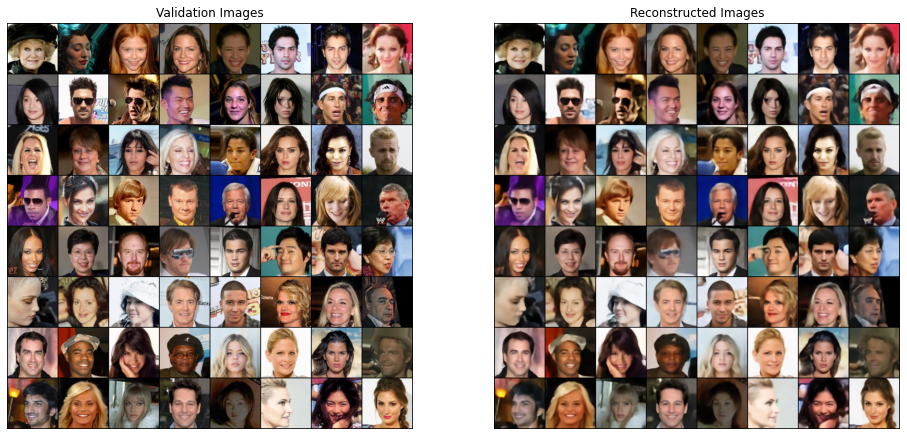

In [46]:
test_batch, _ = next(iter(val_loader))
reconstructed_batch = reconstruct(model, test_batch, DEVICE)
show_2_batches(test_batch[:64], reconstructed_batch[:64], "Validation Images", "Reconstructed Images")

Testing generation

In [53]:
sample_images = model.sample(64)

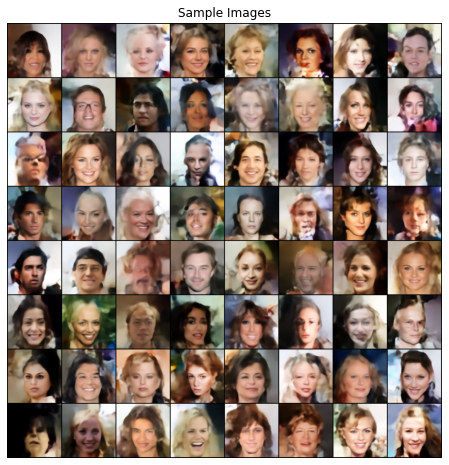

In [54]:
show_images(sample_images.cpu(), "Sample Images")